In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
mnist = pd.read_csv(r'/home/mitesh/files_backup/ExcelR_Ai_ass/CNN/fashion_mnist/fashion-mnist_train.csv')
mnist.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
mnist.shape

(60000, 785)

# Split data into training & testing set :

In [6]:
x = np.array(mnist.iloc[:,1:])
y = np.array(mnist.iloc[:,0])
print(x.shape, y.shape)

(60000, 784) (60000,)


   # First 25 image :

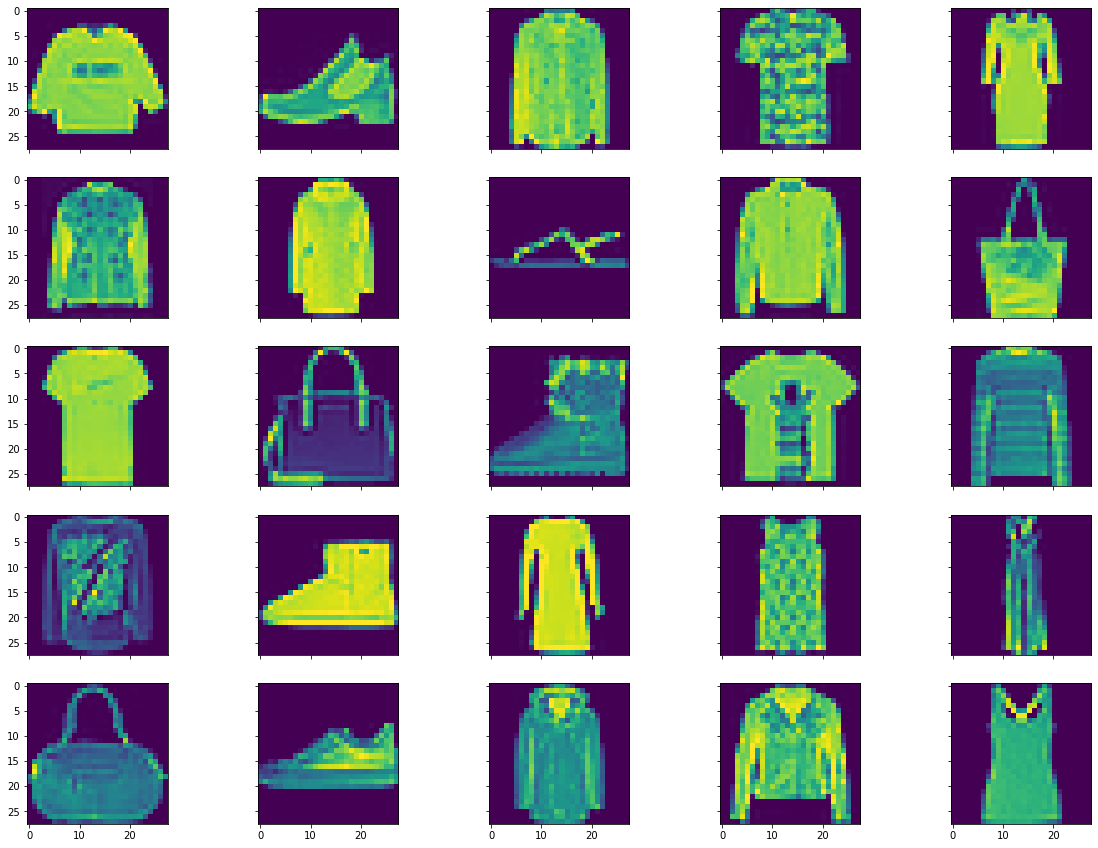

In [8]:
n = 0
rows = 5
cols = 5
fig, ax = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(20,15))
for row in range(rows):
    for col in range(cols):
        ax[row,col].imshow((x[n].reshape(28,28)))
        n += 1

# To categorical using Numpy :

In [18]:
n_values = np.max(y)+1
y_cat = np.eye(n_values)[y]
y_cat

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [20]:
y_cat.shape

(60000, 10)

In [41]:
i = (80)/100
x_train = x[0:int(i*len(x))]
x_test = x[int(i*len(x)):]
y_train = y_cat[0:int(i*len(y_cat))]
y_test = y_cat[int(i*len(y_cat)):]

In [42]:
x_train.shape, x_test.shape

((48000, 784), (12000, 784))

In [43]:
y_train.shape, y_test.shape

((48000, 10), (12000, 10))

In [143]:
from torchvision.datasets import FashionMNIST
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset


In [141]:
train_csv = pd.read_csv("/home/mitesh/files_backup/ExcelR_Ai_ass/CNN/fashion_mnist/fashion-mnist_train.csv")
test_csv = pd.read_csv("/home/mitesh/files_backup/ExcelR_Ai_ass/CNN/fashion_mnist/fashion-mnist_test.csv")

In [144]:
class FashionDataset(Dataset):
    """User defined class to build a datset using Pytorch class Dataset."""
    
    def __init__(self, data, transform = None):
        """Method to initilaize variables.""" 
        self.fashion_MNIST = list(data.values)
        self.transform = transform
        
        label = []
        image = []
        
        for i in self.fashion_MNIST:
             # first column is of labels.
            label.append(i[0])
            image.append(i[1:])
        self.labels = np.asarray(label)
        # Dimension of Images = 28 * 28 * 1. where height = width = 28 and color_channels = 1.
        self.images = np.asarray(image).reshape(-1, 28, 28, 1).astype('float32')

    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)

In [145]:
# Transform data into Tensor that has a range from 0 to 1
train_set = FashionDataset(train_csv, transform=transforms.Compose([transforms.ToTensor()]))
test_set = FashionDataset(test_csv, transform=transforms.Compose([transforms.ToTensor()]))

train_loader = DataLoader(train_set, batch_size=100)
test_loader = DataLoader(train_set, batch_size=100)

# Custom Neural Network :

In [146]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

# Define a convolution neural network
class Network(nn.Module):
    
    def __init__(self):
        super(Network, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [147]:
# Initialise Model :
model = Network()

# Define Loss Fuction :

In [148]:
from torch.optim import Adam

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

# Train Fuction :

In [149]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [150]:
num_epochs = 10
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        # Forward pass 
#         print(train)
        outputs = model(train)
        loss = loss_fn(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    
        count += 1
    
    # Testing the model
    
        if not (count % 50):    # It's same as "if count % 50 == 0"
            total = 0
            correct = 0
        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
            
                test = Variable(images.view(100, 1, 28, 28))
            
                outputs = model(test)
            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.5119532942771912, Accuracy: 86.96833038330078%
Iteration: 1000, Loss: 0.2893844544887543, Accuracy: 90.3183364868164%
Iteration: 1500, Loss: 0.2555733025074005, Accuracy: 90.32499694824219%
Iteration: 2000, Loss: 0.2813304364681244, Accuracy: 91.95833587646484%
Iteration: 2500, Loss: 0.2368667721748352, Accuracy: 92.44666290283203%
Iteration: 3000, Loss: 0.21864597499370575, Accuracy: 93.4316635131836%
Iteration: 3500, Loss: 0.32574501633644104, Accuracy: 92.41166687011719%
Iteration: 4000, Loss: 0.270433247089386, Accuracy: 92.11499786376953%
Iteration: 4500, Loss: 0.2333068996667862, Accuracy: 92.18000030517578%
Iteration: 5000, Loss: 0.17534534633159637, Accuracy: 93.62166595458984%
Iteration: 5500, Loss: 0.2384321540594101, Accuracy: 93.4316635131836%
Iteration: 6000, Loss: 0.17725864052772522, Accuracy: 94.58833312988281%


# Loss :

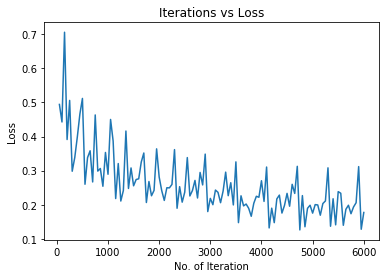

In [152]:
plt.plot(iteration_list, loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

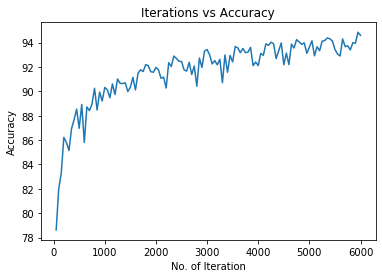

In [153]:
plt.plot(iteration_list, accuracy_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

In [155]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [156]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Accuracy of T-shirt/Top: 91.00%
Accuracy of Trouser: 99.92%
Accuracy of Pullover: 94.50%
Accuracy of Dress: 94.60%
Accuracy of Coat: 88.28%
Accuracy of Sandal: 98.82%
Accuracy of Shirt: 83.75%
Accuracy of Sneaker: 95.97%
Accuracy of Bag: 98.53%
Accuracy of Ankle Boot: 99.48%
